In [1]:
from collections import defaultdict
import pandas as pd
import pickle as pkl
import os


def get_evidence_df(ann_folder):
    rows = {}
    for filename in os.listdir(ann_folder):
        with open(os.path.join(ann_folder, filename), 'rb') as f:
            d = pkl.load(f)
            instance_data = next(iter(d.values()))
            anns = instance_data['model_anns']
            if len(anns) > 0:
                assert len(anns) == 1
                model_type = next(iter(anns.keys()))
                anns['model_type'] = model_type
                model_anns = anns[model_type]
                if len(model_anns) > 0:
                    assert len(model_anns['sort_by_model_order']) == 1
                    sort_type = model_anns['sort_by_model_order'][0]
                    anns['sort_type'] = sort_type
                    del model_anns['sort_by_model_order']
                    model_anns['evidence_anns'] = model_anns['evidence_anns'][sort_type]
                    anns.update(model_anns)
                del anns[model_type]
            del instance_data['model_anns']
            instance_data.update(instance_data['info'])
            del instance_data['info']
            instance_data.update(anns)
            rows.update(d)
    return pd.DataFrame(rows).transpose().sort_index()


def get_full_evidence_df(ann_dirs):
    dfs = defaultdict(lambda : pd.DataFrame([]))
    for ann_dir in ann_dirs:
        date = '_'.join(ann_dir.split('/')[-2].split('_')[1:])
        for split in os.listdir(ann_dir):
            for annotator in os.listdir(os.path.join(ann_dir, split)):
                df = get_evidence_df(os.path.join(ann_dir, split, annotator))
                df['annotator'] = [annotator] * len(df)
                df['date'] = [date] * len(df)
                dfs[split] = pd.concat([dfs[split], df])
    dfs = {split: df.reset_index() for split, df in dfs.items()}
    annotator_instance_repeats = defaultdict(lambda: [])
    for split, df in dfs.items():
        annotations_to_remove = set()
        for annotator in set(df.annotator):
            annotator_df = df[df.annotator == annotator]
            for instance in set(annotator_df.instance):
                annotator_instance_df = annotator_df[
                    annotator_df.instance == instance]
                if len(annotator_instance_df) > 1:
                    annotator_instance_repeats[split].append(annotator_instance_df)
                    annotations_to_remove.update(set(annotator_instance_df[1:].index))
        dfs[split] = df.drop(index=list(annotations_to_remove))
    return dfs, dict(annotator_instance_repeats)


In [2]:
dfs, annotator_instance_repeats = get_full_evidence_df([
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-29-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-3-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-9-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-14-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-16-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-17-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-20-23/annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-20-23_extra/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-21-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-30-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_12-11-23/annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_12-14-23/annotations',
    ])

In [3]:
print(annotator_instance_repeats.keys())
# print(len(annotator_instance_repeats['val2']))
# annotator_instance_repeats['val2'][0]

dict_keys([])


In [4]:
# dfs['val2'][dfs['val2'].instance == "val2 Instance 69 (patient 11480, 158 reports)"]

In [5]:
dfs['val2']['evidence_anns'].iloc[0]

{10: {'cancer': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'pneumonia': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'pulmonary edema': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'evidence_was_seen': 'Yes',
  'notes': 'Only one piece of relevant evidence because huge gap in the medical record between recent report and past reports.',
  'evidence': {'score': '0.96',
   'evidence': "The liver is nodular and coarse in echotexture, consistent with patient's history of known cirrhosis. The gallbladder wall is thickened, with a dependent gallstone within it. A moderate amount of",
   'query': 'cancer (diagnosis)',
   'day': -387,
   'report_number': '20'},
  'sorted_idx': 0,
  'evidence_distribution': [2.884256362915039,
   -2.276189088821411,
   -1.170615315437317]}}

In [6]:
dfs['val2']

,index,obs,timestep,num_reports,instance,time_for_initial_assesment,seen_targets,option_likelihood_anns,max_timesteps,true_positives,...,options,selected_options,option_likelihood_anns2,concluding_notes,invalid_instance_notes,annotator,date,action,visited_reports,visited_report_timestamps
0,0,"{'options': 'option,type cancer,diagnosis pneu...",1,26,"val2 Instance 50 (patient 11755, 122 reports)",168.272657,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",19,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,9-29-23,NaN,NaN,NaN
1,1,"{'options': 'option,type cancer,diagnosis pneu...",1,42,"val2 Instance 51 (patient 7470, 53 reports)",189.534721,{pulmonary edema (diagnosis)},NaN,21,None,...,NaN,NaN,NaN,NaN,,Andrea,9-29-23,NaN,NaN,NaN
2,2,"{'options': 'option,type cancer,diagnosis pneu...",1,1,"val2 Instance 52 (patient 83375, 8 reports)",24.683878,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",7,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,9-29-23,NaN,NaN,NaN
3,3,"{'options': 'option,type cancer,diagnosis pneu...",1,2,"val2 Instance 53 (patient 94023, 4 reports)",29.90608,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,9-29-23,NaN,NaN,NaN
4,4,"{'options': 'option,type cancer,diagnosis pneu...",1,2,"val2 Instance 54 (patient 26310, 32 reports)",46.365206,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,9-29-23,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,5,"{'options': 'option,type cancer,diagnosis pneu...",1,34,"val2 Instance 95 (patient 79511, 75 reports)",205.561148,{},"{'cancer (diagnosis)': 'Very likely', 'pneumon...",25,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Very likely', 'pneumon...",,NaN,Geoff,11-30-23,"[-2.4526724815368652, -1.8406120538711548, -1....","[34. 109613.0 - General: ""Clinician: Attendin...","[0.001026153564453125, 88.60719799995422, 170...."
58,0,"{'options': 'option,type cancer,diagnosis pneu...",1,19,"val2 Instance 140 (patient 8134, 24 reports)",202.630398,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",9,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Geoff,12-11-23,"[-3.584925889968872, -0.8680037260055542, -2.5...","[19. 112290.0 - Nursing/other: ""NPN 1900-0700""...","[0.0007960796356201172, 20.056910276412964, 45..."
59,1,"{'options': 'option,type cancer,diagnosis pneu...",1,30,"val2 Instance 142 (patient 17285, 32 reports)",116.847206,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Geoff,12-11-23,"[-3.5986549854278564, -0.8498951196670532, -2....","[30. 148050.0 - Discharge summary: ""Admission ...","[0.0007696151733398438, 116.84514999389648]"
60,2,"{'options': 'option,type cancer,diagnosis pneu...",1,18,"val2 Instance 145 (patient 28084, 22 reports)",146.954827,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",7,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Very likely', 'pneumon...",Changed for cancer because the patient actuall...,NaN,Geoff,12-11-23,"[-3.347614288330078, -2.123823404312134, -1.16...","[18. 129941.0 - ECG: ""Sinus rhythm with prolon...","[0.0008106231689453125, 40.39545917510986, 96...."


In [7]:
print(len(set(dfs['val2'].instance_index)))
print(set(dfs['val2'].instance_index))

28
{0, 135, 136, 137, 139, 141, 144, 149, 49, 50, 51, 52, 53, 54, 62, 66, 68, 75, 84, 86, 94, 97, 105, 107, 111, 117, 121, 127}


In [8]:

dfs['val2'][dfs['val2'].instance == "val2 Instance 69 (patient 11480, 158 reports)"]

,index,obs,timestep,num_reports,instance,time_for_initial_assesment,seen_targets,option_likelihood_anns,max_timesteps,true_positives,...,options,selected_options,option_likelihood_anns2,concluding_notes,invalid_instance_notes,annotator,date,action,visited_reports,visited_report_timestamps
7,2,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",155.551828,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,11-3-23,"[-5.879974842071533, -1.8629225492477417, -2.7...",NaN,NaN
15,0,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",271.838545,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,William,11-3-23,"[-3.64162540435791, -2.0485668182373047, -1.93...",NaN,NaN
52,0,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",216.654062,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Geoff,11-30-23,"[-3.64162540435791, -2.0485668182373047, -1.93...","[10. 198151.0 - Radiology: ""[**2180-10-18**] 1...","[0.0006823539733886719, 77.55505967140198, 216..."


In [9]:
from collections import defaultdict
def get_processed_annotations(df, remove_duplicates=True):
    new_rows = []
    for i, row in df.iterrows():
        new_rows.append({
            'annotator': row['annotator'],
            'instance_index': row['instance_index'],
            'num_reports': row['num_reports'],
            'model_type': row['model_type'],
            'sort_type': row['sort_type'],
            'prediction_aligns': 1 if row['prediction_aligns'] == 'Yes' else 0 if row['prediction_aligns'] == row['prediction_aligns'] else None,
            'time_for_initial_assesment': row['time_for_initial_assesment'],
        })
        if row['options'] == row['options']:
            for condition in row['options']:
                condition = condition.split(' (')[0]
                new_rows[-1][condition + ' in future'] = condition in row['future_true_positives']
            evidence_anns = sorted([{'idx': k, **v} for k, v in row['evidence_anns'].items()], key=lambda x: x['sorted_idx'])
            new_evidence_anns = defaultdict(lambda: [])
            new_rows[-1]['num_annotated_evidence'] = len(evidence_anns)
            for x in evidence_anns:
                is_duplicate = 'duplicate' in x['notes'].lower() \
                    if 'notes' in x.keys() else False
                if remove_duplicates and is_duplicate:
                    continue
                new_evidence_anns['is_duplicate'].append(is_duplicate)
                new_evidence_anns['notes'].append(
                    x['notes'] if 'notes' in x.keys() else None)
                evidence_info = x['evidence']
                for k, v in evidence_info.items():
                    new_evidence_anns[k].append(v)
                new_evidence_anns['evidence_was_seen'].append(
                    x['evidence_was_seen'] if 'evidence_was_seen' in x.keys()
                    else None)
                for condition in row['options']:
                    condition = condition.split(' (')[0]
                    new_evidence_anns[condition + ' relevance'].append(int(
                        x[condition]['relevance'].split()[0]))
                    new_evidence_anns[condition + ' impact'].append(
                        x[condition]['impact'] if 'impact' in x[condition].keys()
                        else None)
            new_rows[-1].update(new_evidence_anns)
        if row['option_likelihood_anns'] == row['option_likelihood_anns']:
            new_rows[-1].update({k.split(' (')[0]: v for k, v in row['option_likelihood_anns'].items()})
            new_rows[-1].update({k.split(' (')[0] + '(changed)': v for k, v in row['option_likelihood_anns2'].items() if v != row['option_likelihood_anns'][k]})
    new_df = pd.DataFrame(new_rows)
    return new_df


In [10]:
processed_df = get_processed_annotations(dfs['val2'])
processed_df

,annotator,instance_index,num_reports,model_type,sort_type,prediction_aligns,time_for_initial_assesment,cancer in future,pneumonia in future,pulmonary edema in future,...,pneumonia relevance,pneumonia impact,pulmonary edema relevance,pulmonary edema impact,cancer,pneumonia,pulmonary edema,cancer(changed),pneumonia(changed),pulmonary edema(changed)
0,Andrea,49,26,llm_evidence,LLM Confidence,1.0,168.272657,False,True,True,...,[1],[Yes],[1],[Yes],Unlikely,Somewhat likely,Somewhat likely,NaN,NaN,NaN
1,Andrea,50,42,llm_evidence,NaN,NaN,189.534721,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Andrea,51,1,llm_evidence,LLM Confidence,0.0,24.683878,False,False,True,...,"[1, 0]","[No, None]","[1, 0]","[No, None]",Unlikely,Unlikely,Unlikely,NaN,NaN,NaN
3,Andrea,52,2,llm_evidence,LLM Confidence,1.0,29.906080,False,False,False,...,"[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]",Unlikely,Unlikely,Somewhat likely,NaN,NaN,NaN
4,Andrea,53,2,llm_evidence,Sort by MSE with the bias logits,0.0,46.365206,False,False,True,...,[1],[Yes],[1],[Yes],Unlikely,Unlikely,Unlikely,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Geoff,94,34,llm_evidence,LLM Confidence,0.0,205.561148,True,True,False,...,"[0, 0, 0]","[None, None, None]","[1, 0, 0]","[Yes, None, None]",Very likely,Unlikely,Very likely,NaN,NaN,NaN
58,Geoff,139,19,all_sentences,Sort by MSE with the bias logits,1.0,202.630398,False,False,False,...,"[0, 1, 0, 0, 3]","[None, No, None, None, Yes]","[1, 0, 0, 0, 0]","[Yes, None, None, None, None]",Unlikely,Somewhat likely,Somewhat likely,NaN,Very likely,Unlikely
59,Geoff,141,30,llm_evidence,LLM Confidence,0.0,116.847206,False,False,False,...,"[0, 0, 1, 0]","[None, None, Yes, None]","[0, 0, 0, 0]","[None, None, None, None]",Unlikely,Unlikely,Unlikely,NaN,NaN,NaN
60,Geoff,144,18,llm_evidence,Sort by MSE with the bias logits,1.0,146.954827,False,False,False,...,"[0, 1, 0, 0]","[None, Yes, None, None]","[0, 0, 2, 0]","[None, None, Yes, None]",Unlikely,Unlikely,Unlikely,Very likely,NaN,NaN


In [11]:
processed_df.sort_values('instance_index')

,annotator,instance_index,num_reports,model_type,sort_type,prediction_aligns,time_for_initial_assesment,cancer in future,pneumonia in future,pulmonary edema in future,...,pneumonia relevance,pneumonia impact,pulmonary edema relevance,pulmonary edema impact,cancer,pneumonia,pulmonary edema,cancer(changed),pneumonia(changed),pulmonary edema(changed)
29,William,0,32,llm_evidence,LLM Confidence,0.0,256.382726,False,False,False,...,"[0, 1]","[None, No]","[0, 1]","[None, No]",Unlikely,Unlikely,Very likely,NaN,NaN,NaN
20,Andrea,0,32,all_sentences,Sort by MSE with the bias logits,1.0,316.974368,False,False,False,...,"[0, 0]","[None, None]","[1, 0]","[Yes, None]",Unlikely,Unlikely,Unlikely,NaN,NaN,NaN
12,Lucy,0,32,llm_evidence,Sort by MSE with the bias logits,0.0,562.725846,False,False,False,...,"[0, 2]","[None, Yes]","[0, 2]","[None, No]",Unlikely,Unlikely,Somewhat likely,NaN,NaN,NaN
0,Andrea,49,26,llm_evidence,LLM Confidence,1.0,168.272657,False,True,True,...,[1],[Yes],[1],[Yes],Unlikely,Somewhat likely,Somewhat likely,NaN,NaN,NaN
32,Geoff,49,26,all_sentences,Sort by MSE with the bias logits,0.0,166.758686,False,True,True,...,"[1, 0]","[No, None]","[1, 1]","[No, Yes]",Somewhat likely,Somewhat likely,Somewhat likely,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,Geoff,137,13,llm_evidence,LLM Confidence,1.0,51.844281,False,False,True,...,"[0, 0, 0]","[None, None, None]","[2, 2, 2]","[Yes, No, Yes]",Unlikely,Unlikely,Unlikely,NaN,NaN,Somewhat likely
58,Geoff,139,19,all_sentences,Sort by MSE with the bias logits,1.0,202.630398,False,False,False,...,"[0, 1, 0, 0, 3]","[None, No, None, None, Yes]","[1, 0, 0, 0, 0]","[Yes, None, None, None, None]",Unlikely,Somewhat likely,Somewhat likely,NaN,Very likely,Unlikely
59,Geoff,141,30,llm_evidence,LLM Confidence,0.0,116.847206,False,False,False,...,"[0, 0, 1, 0]","[None, None, Yes, None]","[0, 0, 0, 0]","[None, None, None, None]",Unlikely,Unlikely,Unlikely,NaN,NaN,NaN
60,Geoff,144,18,llm_evidence,Sort by MSE with the bias logits,1.0,146.954827,False,False,False,...,"[0, 1, 0, 0]","[None, Yes, None, None]","[0, 0, 2, 0]","[None, None, Yes, None]",Unlikely,Unlikely,Unlikely,Very likely,NaN,NaN


In [12]:
processed_df.keys()

Index(['annotator', 'instance_index', 'num_reports', 'model_type', 'sort_type',
       'prediction_aligns', 'time_for_initial_assesment', 'cancer in future',
       'pneumonia in future', 'pulmonary edema in future',
       'num_annotated_evidence', 'is_duplicate', 'notes', 'score', 'evidence',
       'query', 'day', 'report_number', 'evidence_was_seen',
       'cancer relevance', 'cancer impact', 'pneumonia relevance',
       'pneumonia impact', 'pulmonary edema relevance',
       'pulmonary edema impact', 'cancer', 'pneumonia', 'pulmonary edema',
       'cancer(changed)', 'pneumonia(changed)', 'pulmonary edema(changed)'],
      dtype='object')

<Axes: xlabel='time_for_initial_assesment', ylabel='precentage_seen'>

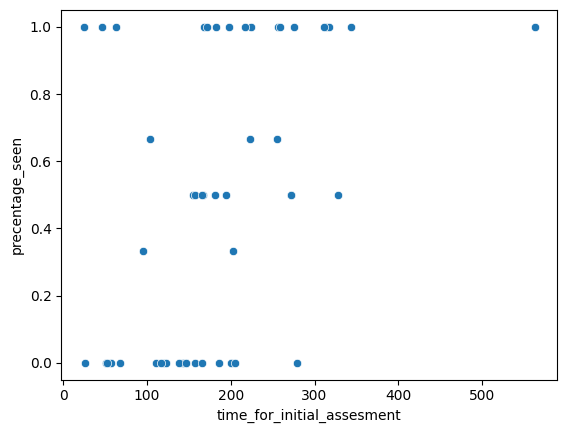

In [13]:
import seaborn as sns
def get_evidence_percentage_seen(x):
    if x != x:
        return float('nan')
    is_yes = [i=='Yes' for i in x if i is not None]
    if len(is_yes) == 0:
        return float('nan')
    return sum(is_yes) / len(is_yes)
processed_df['precentage_seen'] = processed_df.evidence_was_seen.apply(get_evidence_percentage_seen)
sns.scatterplot(processed_df, x='time_for_initial_assesment', y='precentage_seen')


In [14]:
evidence_df = []
for i, row in processed_df.iterrows():
    if row['evidence'] != row['evidence']:
        continue
    evidence_info_keys = [
        'notes', 'query', 'day', 'evidence_was_seen', 'cancer impact',
        'pneumonia impact', 'pulmonary edema impact', 'cancer relevance',
        'pneumonia relevance', 'pulmonary edema relevance']
    for j, evidence_info in enumerate(list(zip(*[
            row[key] if row[key] == row[key] else [None] * len(row['evidence'])
            for key in evidence_info_keys]))):
        # import pdb; pdb.set_trace()
        evidence_df.append({
            'annotator': row['annotator'],
            'model_type': row['model_type'],
            'sort_type': row['sort_type'],
            'instance_index': row['instance_index'],
        })
        evidence_df[-1].update({
            k: v for k, v in zip(evidence_info_keys, evidence_info)
            if v is not None})
        impact_keys = [
            x for x in [
                'cancer impact', 'pneumonia impact', 'pulmonary edema impact']
                if x in evidence_df[-1].keys()]
        if len(impact_keys) > 0:
            evidence_df[-1]['avg_impact'] = sum([
                evidence_df[-1][x]=='Yes' for x in impact_keys]) / len(impact_keys)
        relevance_keys = [
            x for x in [
                'cancer relevance', 'pneumonia relevance',
                'pulmonary edema relevance']
                if x in evidence_df[-1].keys()]
        if len(relevance_keys) > 0:
            evidence_df[-1]['Usefulness'] = max([
                evidence_df[-1][x] for x in relevance_keys])
        for usefulness, key in enumerate([
                'Not Relevant', 'Weak Correlation', 'Useful', 'Very Useful']):
            evidence_df[-1][key] = 1 \
                if usefulness == evidence_df[-1]['Usefulness'] else 0
        evidence_df[-1]['count'] = 1

    # all_notes = row['notes'] if row['notes'] == row['notes'] else [None] * len(row['evidence'])
    # all_queries = row['query'] if row['query'] == row['query'] else [None] * len(row['evidence'])
    # all_days = row['day'] if row['day'] == row['day'] else [None] * len(row['day'])
    # evidence_was_seen = row['evidence_was_seen'] if row['evidence_was_seen'] == row['evidence_was_seen'] else [None] * len(row['evidence_was_seen'])
    # impacts = {}
    # if row['cancer impact'] == row['cancer impact']:
    #     impacts['cancer'] = row['cancer impact']
    # if row['pneumonia impact'] == row['pneumonia impact']:
    #     impacts['pneumonia'] = row['pneumonia impact']
    # if row['pulmonary edema impact'] == row['pulmonary edema impact']:
    #     impacts['pulmonary edema'] = row['pulmonary edema impact']
    # keys = list(impacts.keys())
    # for j, (evidence, notes, query, day, evid_seen, impact) in enumerate(zip(
    #         row['evidence'], all_notes, all_queries, all_days,
    #         evidence_was_seen, zip(*[impacts[key] for key in keys]))):
    #     evidence_df.append({
    #         'annotator': row['annotator'],
    #         'model_type': row['model_type'],
    #         'sort_type': row['sort_type'],
    #         'instance_index': row['instance_index'],
    #         'notes': notes,
    #         'evidence': evidence,
    #         'query': query,
    #         'day': day,
    #         'evidence_was_seen': evid_seen,
    #     })
    #     keys_temp = [k for k, im in zip(keys, impact) if im is not None]
    #     impact_temp = [1 if im=='Yes' else 0 for im in impact if im is not None]
    #     if len(impact_temp) > 0:
    #         avg_impact = sum(impact_temp) / len(impact_temp)
    #         evidence_df[-1]['avg_impact'] = avg_impact
    #         for key, im in zip(keys_temp, impact_temp):
    #             evidence_df[-1][key + ' impact'] = im
evidence_df = pd.DataFrame(evidence_df)
evidence_df['model'] = evidence_df.apply(lambda r: str((r.model_type, r.sort_type)), axis=1)
evidence_df

,annotator,model_type,sort_type,instance_index,notes,query,day,evidence_was_seen,cancer impact,pneumonia impact,...,pneumonia relevance,pulmonary edema relevance,avg_impact,Usefulness,Not Relevant,Weak Correlation,Useful,Very Useful,count,model
0,Andrea,llm_evidence,LLM Confidence,49,Only one piece of relevant evidence because hu...,cancer (diagnosis),-387,Yes,Yes,Yes,...,1,1,1.0,1,0,1,0,0,1,"('llm_evidence', 'LLM Confidence')"
1,Andrea,llm_evidence,LLM Confidence,51,,pulmonary edema (diagnosis),0,Yes,NaN,No,...,1,1,0.0,1,0,1,0,0,1,"('llm_evidence', 'LLM Confidence')"
2,Andrea,llm_evidence,LLM Confidence,51,,pneumonia (diagnosis),0,NaN,NaN,NaN,...,0,0,NaN,0,1,0,0,0,1,"('llm_evidence', 'LLM Confidence')"
3,Andrea,llm_evidence,LLM Confidence,52,,pulmonary edema (diagnosis),-15,NaN,NaN,NaN,...,0,0,NaN,0,1,0,0,0,1,"('llm_evidence', 'LLM Confidence')"
4,Andrea,llm_evidence,LLM Confidence,52,,tiredness (risk factor),-15,NaN,NaN,NaN,...,0,0,NaN,0,1,0,0,0,1,"('llm_evidence', 'LLM Confidence')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,Geoff,llm_evidence,Sort by MSE with the bias logits,144,,pulmonary edema (diagnosis),-5,No,NaN,NaN,...,0,2,1.0,2,0,0,1,0,1,"('llm_evidence', 'Sort by MSE with the bias lo..."
160,Geoff,llm_evidence,Sort by MSE with the bias logits,144,,pulmonary edema (diagnosis),-5,NaN,NaN,NaN,...,0,0,NaN,0,1,0,0,0,1,"('llm_evidence', 'Sort by MSE with the bias lo..."
161,Geoff,llm_evidence,Sort by MSE with the bias logits,149,,cancer (diagnosis),-643,Yes,Yes,NaN,...,0,0,1.0,1,0,1,0,0,1,"('llm_evidence', 'Sort by MSE with the bias lo..."
162,Geoff,llm_evidence,Sort by MSE with the bias logits,149,,cancer (diagnosis),-527,Yes,Yes,NaN,...,0,0,1.0,1,0,1,0,0,1,"('llm_evidence', 'Sort by MSE with the bias lo..."


In [15]:
print(evidence_df[evidence_df.instance_index==75].iloc[-2])
print(evidence_df[evidence_df.instance_index==75].iloc[-1])

annotator                                                  Lucy
model_type                                         llm_evidence
sort_type                                        LLM Confidence
instance_index                                               75
notes                                                          
query                                  chest pain (risk factor)
day                                                          -1
evidence_was_seen                                            No
cancer impact                                                No
pneumonia impact                                             No
pulmonary edema impact                                       No
cancer relevance                                              1
pneumonia relevance                                           2
pulmonary edema relevance                                     2
avg_impact                                                  0.0
Usefulness                              

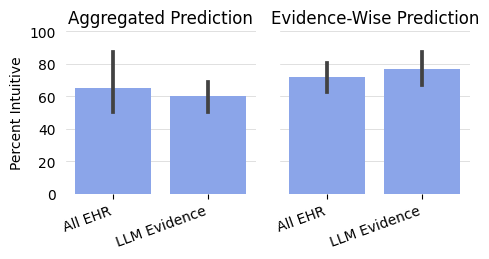

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 2, figsize=(4.9, 2.7), sharey=True)
processed_df_temp = processed_df.copy()
models = {'llm_evidence': 'LLM Evidence', 'all_sentences': 'All EHR'}
processed_df_temp['model_type'] = processed_df_temp['model_type'].apply(
    lambda x: models[x])
processed_df_temp = processed_df_temp.groupby(['annotator', 'model_type']).agg({'prediction_aligns': np.mean}).reset_index()
processed_df_temp['prediction_aligns'] = processed_df_temp['prediction_aligns'] * 100
processed_df_temp = pd.concat([processed_df_temp[processed_df_temp.model_type == mt] for mt in ['All EHR', 'LLM Evidence']])
sns.barplot(data=processed_df_temp.rename(columns={'prediction_aligns': 'Percent Intuitive', 'model_type': 'Model'}),
            y='Percent Intuitive', x='Model', ax=axs[0], color=sns.color_palette("coolwarm", 4)[0])
axs[0].set_title('Aggregated Prediction', fontsize=12)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].set_xlabel('')
evidence_df_temp = evidence_df.copy()
evidence_df_temp['model_type'] = evidence_df_temp['model_type'].apply(
    lambda x: models[x])
evidence_df_temp = evidence_df_temp.groupby(['annotator', 'model_type']).agg({'avg_impact': np.mean}).reset_index()
evidence_df_temp['avg_impact'] = evidence_df_temp['avg_impact'] * 100
evidence_df_temp = pd.concat([evidence_df_temp[evidence_df_temp.model_type == mt] for mt in ['All EHR', 'LLM Evidence']])
sns.barplot(
    data=evidence_df_temp.rename(columns={'avg_impact': 'Percent Intuitive', 'model_type': 'Model'}),
    y='Percent Intuitive', x='Model', ax=axs[1], color=sns.color_palette("coolwarm", 4)[0])
axs[1].set_title('Evidence-Wise Prediction', fontsize=12)
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticklabels(
    axs[1].get_xticklabels(),
    rotation=20,
    horizontalalignment='right'
)
axs[0].set_xticklabels(
    axs[0].get_xticklabels(),
    rotation=20, 
    horizontalalignment='right'
)
axs[0].set_ylim(0, 100)
# axs[0].yaxis.set_tick_params(width=0)
axs[1].grid(True, axis='y', linestyle='-', linewidth=0.5, color='lightgray')
axs[1].yaxis.set_tick_params(width=0)
axs[1].set_axisbelow(True)
axs[0].grid(True, axis='y', linestyle='-', linewidth=0.5, color='lightgray')
axs[0].yaxis.set_tick_params(width=0)
axs[0].set_axisbelow(True)
fig.tight_layout()
fig.savefig('figures/percent_intuitive.pdf')

<Axes: xlabel='num_reports', ylabel='time_for_initial_assesment'>

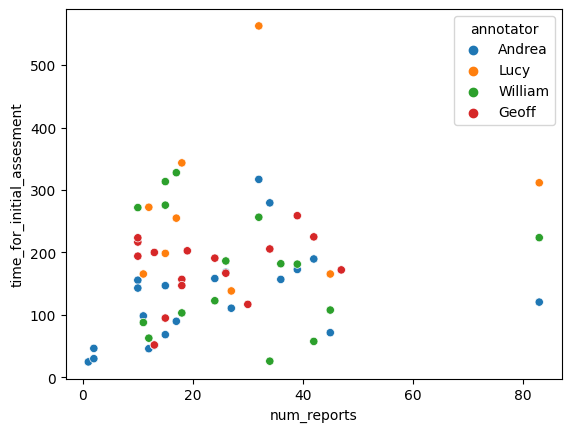

In [17]:
import seaborn as sns
sns.scatterplot(data=processed_df, x='num_reports', y='time_for_initial_assesment', hue='annotator')

In [20]:
processed_df.time_for_initial_assesment.mean()

172.04031177874535

In [22]:
processed_df.num_annotated_evidence.mean()

3.189655172413793

In [18]:
evidence_df.keys()

Index(['annotator', 'model_type', 'sort_type', 'instance_index', 'notes',
       'query', 'day', 'evidence_was_seen', 'cancer impact',
       'pneumonia impact', 'pulmonary edema impact', 'cancer relevance',
       'pneumonia relevance', 'pulmonary edema relevance', 'avg_impact',
       'Usefulness', 'Not Relevant', 'Weak Correlation', 'Useful',
       'Very Useful', 'count', 'model'],
      dtype='object')

In [19]:
evidence_df

,annotator,model_type,sort_type,instance_index,notes,query,day,evidence_was_seen,cancer impact,pneumonia impact,...,pneumonia relevance,pulmonary edema relevance,avg_impact,Usefulness,Not Relevant,Weak Correlation,Useful,Very Useful,count,model
0,Andrea,llm_evidence,LLM Confidence,49,Only one piece of relevant evidence because hu...,cancer (diagnosis),-387,Yes,Yes,Yes,...,1,1,1.0,1,0,1,0,0,1,"('llm_evidence', 'LLM Confidence')"
1,Andrea,llm_evidence,LLM Confidence,51,,pulmonary edema (diagnosis),0,Yes,NaN,No,...,1,1,0.0,1,0,1,0,0,1,"('llm_evidence', 'LLM Confidence')"
2,Andrea,llm_evidence,LLM Confidence,51,,pneumonia (diagnosis),0,NaN,NaN,NaN,...,0,0,NaN,0,1,0,0,0,1,"('llm_evidence', 'LLM Confidence')"
3,Andrea,llm_evidence,LLM Confidence,52,,pulmonary edema (diagnosis),-15,NaN,NaN,NaN,...,0,0,NaN,0,1,0,0,0,1,"('llm_evidence', 'LLM Confidence')"
4,Andrea,llm_evidence,LLM Confidence,52,,tiredness (risk factor),-15,NaN,NaN,NaN,...,0,0,NaN,0,1,0,0,0,1,"('llm_evidence', 'LLM Confidence')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,Geoff,llm_evidence,Sort by MSE with the bias logits,144,,pulmonary edema (diagnosis),-5,No,NaN,NaN,...,0,2,1.0,2,0,0,1,0,1,"('llm_evidence', 'Sort by MSE with the bias lo..."
160,Geoff,llm_evidence,Sort by MSE with the bias logits,144,,pulmonary edema (diagnosis),-5,NaN,NaN,NaN,...,0,0,NaN,0,1,0,0,0,1,"('llm_evidence', 'Sort by MSE with the bias lo..."
161,Geoff,llm_evidence,Sort by MSE with the bias logits,149,,cancer (diagnosis),-643,Yes,Yes,NaN,...,0,0,1.0,1,0,1,0,0,1,"('llm_evidence', 'Sort by MSE with the bias lo..."
162,Geoff,llm_evidence,Sort by MSE with the bias logits,149,,cancer (diagnosis),-527,Yes,Yes,NaN,...,0,0,1.0,1,0,1,0,0,1,"('llm_evidence', 'Sort by MSE with the bias lo..."


In [21]:
def plot_evidence_stacked(evidence_df, filename=None, ax=None, percent=True, horizontal=True):
    df_stacked = evidence_df.groupby(['model'])[
        ['Not Relevant', 'Weak Correlation', 'Useful', 'Very Useful', 'count']].agg(np.sum).reset_index()
    models = {'llm_evidence': 'LLM Evidence', 'all_sentences': 'All EHR'}
    sort_methods = {'Sort by MSE with the bias logits': 'Log Odds Sorting', 'LLM Confidence': 'Confidence Sorting'}
    df_stacked['Model'] = df_stacked['model'].apply(lambda x: models[eval(x)[0]]+'\n+'+sort_methods[eval(x)[1]])
    df_stacked = df_stacked.set_index('Model')
    ratings = ['Very Useful', 'Useful', 'Weak Correlation', 'Not Relevant']
    if percent:
        for x in ratings:
            df_stacked[x] = df_stacked.apply(lambda r: 100 * r[x] / r['count'], axis=1)
    df_stacked = pd.concat([
        df_stacked[df_stacked.index=='LLM Evidence\n+Log Odds Sorting'],
        df_stacked[df_stacked.index=='All EHR\n+Log Odds Sorting'],
        df_stacked[df_stacked.index=='LLM Evidence\n+Confidence Sorting'],
    ])
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4.8, 3.2))
    else:
        fig = None
    df_stacked_temp = df_stacked.copy()
    if percent:
        df_stacked_temp = df_stacked_temp.rename(index={
            k: f'{k}\n(n={int(v)})' for k, v in df_stacked['count'].to_dict().items()})
    chart = df_stacked_temp[
        ['Very Useful', 'Useful', 'Weak Correlation', 'Not Relevant']].plot(
        kind='barh' if horizontal else 'bar', stacked=True,
        color=sns.color_palette("coolwarm", 4),
        width=0.75,
        ax=ax)
    measure = 'Evidence Percent' if percent else 'Evidence Count'
    chart.set_ylabel('' if horizontal else measure)
    chart.set_xlabel(measure if horizontal else '')
    chart.legend(
        prop={'size': 11}, ncol=2, loc="upper center",
        bbox_to_anchor=(0.4, 1.3), frameon=False)
    if horizontal:
        chart.set_yticklabels(
            chart.get_yticklabels(),
            horizontalalignment='left',
            # weight='bold',
            fontsize=11,
        )
        yax = ax.get_yaxis()
        pad = max(T.label1.get_window_extent().width-35 for T in yax.majorTicks)
        yax.set_tick_params(pad=pad)
        if percent:
            chart.axis([0, 100, -.4, 3-.6])
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,)
    else:
        chart.set_xticklabels(
            chart.get_xticklabels(),
            horizontalalignment='right',
            # weight='bold',
            rotation=15,
            fontsize=11,
        )
        if percent:
            chart.axis([-.4, 3-.6, 0, 100])
    # chart.set_xticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if not os.path.exists('figures'):
        os.makedirs("figures")
    if fig is not None:
        fig.tight_layout()
        if filename is not None:
            fig.savefig(filename)

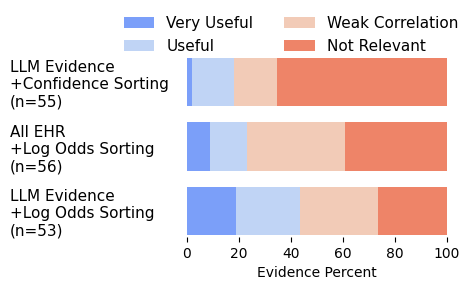

In [22]:
plot_evidence_stacked(evidence_df, filename='figures/model_evidence.pdf')

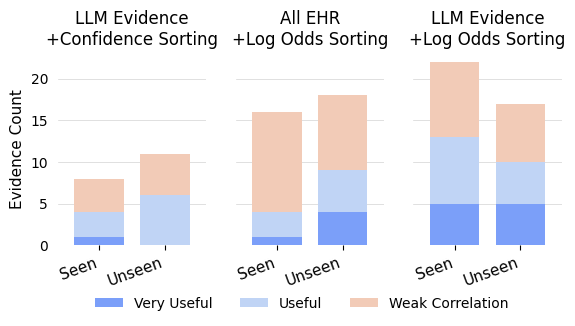

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.5), sharey=True)
df_stacked = evidence_df[~evidence_df.evidence_was_seen.isna()].groupby(['model', 'evidence_was_seen'])[
        ['Weak Correlation', 'Useful', 'Very Useful']].agg(np.sum).reset_index()
models = {'llm_evidence': 'LLM Evidence', 'all_sentences': 'All EHR'}
sort_methods = {'Sort by MSE with the bias logits': 'Log Odds Sorting', 'LLM Confidence': 'Confidence Sorting'}
df_stacked['Model'] = df_stacked['model'].apply(lambda x: models[eval(x)[0]]+'\n+'+sort_methods[eval(x)[1]])
df_stacked['seen_vs_unseen'] = df_stacked['evidence_was_seen'].apply(lambda x: 'Seen' if x=='Yes' else 'Unseen')
df_stacked = pd.concat([df_stacked[df_stacked.seen_vs_unseen == x] for x in ['Seen', 'Unseen']])
df_stacked = df_stacked.set_index('seen_vs_unseen')
ratings = ['Very Useful', 'Useful', 'Weak Correlation']
for i, model in enumerate(['LLM Evidence\n+Confidence Sorting', 'All EHR\n+Log Odds Sorting',
              'LLM Evidence\n+Log Odds Sorting']):
    df_stacked_temp = df_stacked[df_stacked.Model == model]
    chart = df_stacked_temp[
        ['Very Useful', 'Useful', 'Weak Correlation']].plot(
        kind='bar', stacked=True,
        color=sns.color_palette("coolwarm", 4),
        width=0.75,
        ax=axs[i])
    chart.set_ylabel('Evidence Count', fontsize=11)
    chart.set_xlabel('')
    chart.grid(True, axis='y', linestyle='-', linewidth=0.5, color='lightgray')
    chart.yaxis.set_tick_params(width=0)
    chart.set_axisbelow(True)
    chart.spines['right'].set_visible(False)
    chart.spines['top'].set_visible(False)
    chart.spines['left'].set_visible(False)
    chart.spines['bottom'].set_visible(False)
    chart.get_legend().remove()
    chart.set_xticklabels(
        chart.get_xticklabels(),
        horizontalalignment='right',
        # weight='bold',
        rotation=20,
        fontsize=11,
    )
    # chart.set_ylim(0, 20)
    chart.set_title(model)
# axs[1].legend(
#             prop={'size': 11}, ncol=3, loc="upper center",
#             bbox_to_anchor=(.5, -.2), frameon=False)
handles, labels = axs[2].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='lower center', ncols=3, frameon=False, bbox_to_anchor=(.5, -.2))
fig.savefig('figures/seen_vs_unseen_evidence.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [24]:
processed_df.num_annotated_evidence.mean()

3.189655172413793

In [25]:
processed_df.keys()

Index(['annotator', 'instance_index', 'num_reports', 'model_type', 'sort_type',
       'prediction_aligns', 'time_for_initial_assesment', 'cancer in future',
       'pneumonia in future', 'pulmonary edema in future',
       'num_annotated_evidence', 'is_duplicate', 'notes', 'score', 'evidence',
       'query', 'day', 'report_number', 'evidence_was_seen',
       'cancer relevance', 'cancer impact', 'pneumonia relevance',
       'pneumonia impact', 'pulmonary edema relevance',
       'pulmonary edema impact', 'cancer', 'pneumonia', 'pulmonary edema',
       'cancer(changed)', 'pneumonia(changed)', 'pulmonary edema(changed)',
       'precentage_seen'],
      dtype='object')

In [26]:
# processed_df_temp = processed_df.copy()
# processed_df_temp['Instances Seen'] = [1] * len(processed_df_temp)
# processed_df_temp = processed_df_temp.groupby(['annotator', 'model_type', 'sort_type']).agg(
#     {'count': np.sum, 'num_annotated_evidence': np.sum, 'num_reports': np.sum})
# processed_df_temp
instance_num_reports = {}
for i, row in processed_df.iterrows():
    instance_num_reports[row['instance_index']] = row['num_reports']
print(instance_num_reports)
evidence_df_temp = evidence_df.copy()
evidence_df_temp['Percent Useful'] = evidence_df_temp['Usefulness'].apply(
    lambda x: x if x != x else 100 if x >= 2 else 0)
evidence_df_temp = evidence_df_temp.groupby(['annotator', 'model']).agg({
    'count': np.sum,
    'instance_index': lambda x: set(x),
    'Usefulness': np.mean,
    'Percent Useful': np.mean,
})
evidence_df_temp['Instances'] = evidence_df_temp['instance_index'].apply(
    lambda x: len(x))
evidence_df_temp['Reports'] = evidence_df_temp['instance_index'].apply(
    lambda x: sum([instance_num_reports[i] for i in x]))
evidence_df_temp = evidence_df_temp.reset_index().rename(
    columns={'count': 'Evidence', 'Usefulness': 'Avg. Usefulness'})
evidence_df_temp = evidence_df_temp[['annotator', 'model', 'Instances', 'Evidence', 'Reports', 'Avg. Usefulness', 'Percent Useful']]
evidence_df_temp

{49: 26, 50: 42, 51: 1, 52: 2, 53: 2, 54: 24, 66: 12, 68: 10, 75: 11, 84: 17, 86: 15, 94: 34, 0: 32, 62: 18, 97: 83, 105: 45, 107: 27, 111: 39, 117: 15, 121: 36, 127: 10, 135: 13, 136: 10, 137: 13, 139: 19, 141: 30, 144: 18, 149: 47}


,annotator,model,Instances,Evidence,Reports,Avg. Usefulness,Percent Useful
0,Andrea,"('all_sentences', 'Sort by MSE with the bias l...",5,14,81,0.500000,7.142857
1,Andrea,"('llm_evidence', 'LLM Confidence')",8,20,195,0.250000,5.000000
2,Andrea,"('llm_evidence', 'Sort by MSE with the bias lo...",6,13,154,1.153846,30.769231
3,Geoff,"('all_sentences', 'Sort by MSE with the bias l...",6,20,127,0.900000,20.000000
4,Geoff,"('llm_evidence', 'LLM Confidence')",5,16,132,0.562500,18.750000
5,Geoff,"('llm_evidence', 'Sort by MSE with the bias lo...",4,12,85,1.500000,41.666667
6,Lucy,"('all_sentences', 'Sort by MSE with the bias l...",2,5,72,1.000000,40.000000
7,Lucy,"('llm_evidence', 'LLM Confidence')",2,6,26,1.000000,50.000000
8,Lucy,"('llm_evidence', 'Sort by MSE with the bias lo...",5,14,162,1.357143,50.000000
9,William,"('all_sentences', 'Sort by MSE with the bias l...",6,17,224,1.294118,35.294118


In [27]:
evidence_df_temp_agg = evidence_df_temp.groupby(['model']).agg({
    'Instances': np.sum,
    'Evidence': np.sum,
    'Reports': np.sum,
    'Avg. Usefulness': np.mean,
    'Percent Useful': np.mean,
})
evidence_df_temp_agg

,Instances,Evidence,Reports,Avg. Usefulness,Percent Useful
model,,,,,
"('all_sentences', 'Sort by MSE with the bias logits')",19,56,504,0.923529,25.609244
"('llm_evidence', 'LLM Confidence')",19,55,458,0.645433,24.206731
"('llm_evidence', 'Sort by MSE with the bias logits')",20,53,520,1.359890,43.108974


In [28]:
annotators = {
    '1': 'Andrea',
    '2': 'Lucy',
    '3': 'William',
    '4': 'Geoff',
}
models = {
    'LLM Evidence+Confidence Sorting': ('llm_evidence', 'LLM Confidence'),
    'Raw EHR+Log Odds Sorting': ('all_sentences', 'Sort by MSE with the bias logits'),
    'LLM Evidence+Log Odds Sorting': ('llm_evidence', 'Sort by MSE with the bias logits'),
}
measurements = {
    'Inst.': 'Instances',
    'Evid.': 'Evidence',
    'Rep.': 'Reports',
    'Percent Useful': 'Percent Useful',
}
latex_table = ""
for i, (model, model_key) in enumerate(models.items()):
    latex_table += "& \\multicolumn{4}{c"
    if i < len(models) - 1:
        latex_table += "|"
    latex_table += "}{" + model + "} "
latex_table += "\\\\\nAnnotator "
for model, model_key in models.items():
    for measurement_name, measurement_key in measurements.items():
        latex_table += f"& {measurement_name} "
latex_table += "\\\\\n\hline\n"
for annotator, ann_key in annotators.items():
    latex_table += f"{annotator} "
    for model, model_key in models.items():
        rows = evidence_df_temp[
            (evidence_df_temp.annotator == ann_key) &
            (evidence_df_temp.model == str(model_key))]
        for measurement_name, measurement_key in measurements.items():
            if len(rows) == 0:
                latex_table += "& - "
            else:
                measurement = rows.iloc[0][measurement_key]
                if isinstance(measurement, float):
                    latex_table += "& {:.1f} ".format(measurement)
                else:
                    latex_table += "& {} ".format(measurement)
    latex_table += "\\\\\n"
latex_table += "\hline\nAggregated "
for model, model_key in models.items():
    measurements_agg = evidence_df_temp_agg.loc[str(model_key)]
    for measurement_name, measurement_key in measurements.items():
        measurement = measurements_agg[measurement_key]
        if measurement_name in ['Percent Useful']:
            latex_table += "& {:.1f} ".format(measurement)
        else:
            latex_table += "& {} ".format(int(measurement))
latex_table += "\\\\\n"
print(latex_table)

& \multicolumn{4}{c|}{LLM Evidence+Confidence Sorting} & \multicolumn{4}{c|}{Raw EHR+Log Odds Sorting} & \multicolumn{4}{c}{LLM Evidence+Log Odds Sorting} \\
Annotator & Inst. & Evid. & Rep. & Percent Useful & Inst. & Evid. & Rep. & Percent Useful & Inst. & Evid. & Rep. & Percent Useful \\
\hline
1 & 8 & 20 & 195 & 5.0 & 5 & 14 & 81 & 7.1 & 6 & 13 & 154 & 30.8 \\
2 & 2 & 6 & 26 & 50.0 & 2 & 5 & 72 & 40.0 & 5 & 14 & 162 & 50.0 \\
3 & 4 & 13 & 105 & 23.1 & 6 & 17 & 224 & 35.3 & 5 & 14 & 119 & 50.0 \\
4 & 5 & 16 & 132 & 18.8 & 6 & 20 & 127 & 20.0 & 4 & 12 & 85 & 41.7 \\
\hline
Aggregated & 19 & 55 & 458 & 24.2 & 19 & 56 & 504 & 25.6 & 20 & 53 & 520 & 43.1 \\



In [29]:
from collections import Counter, defaultdict
query_counts = defaultdict(lambda : Counter())
for i, row in processed_df.iterrows():
    relevance_keys = [k for k in row.keys() if k.endswith(' relevance')]
    if row[relevance_keys[0]] == row[relevance_keys[0]] and \
            row['query'] == row['query']:
        for x in zip(row['query'], *[row[k] for k in relevance_keys]):
            query_counts[x[0]][max(x[1:])] += 1
query_counts = pd.DataFrame(query_counts).transpose()
query_counts

,1,3,2,0
cancer (diagnosis),9.0,5.0,2.0,4.0
pulmonary edema (diagnosis),2.0,1.0,3.0,6.0
pneumonia (diagnosis),7.0,2.0,5.0,1.0
tiredness (risk factor),NaN,1.0,NaN,4.0
a low ejection fraction (risk factor),4.0,NaN,5.0,5.0
neuralogical problems (risk factor),1.0,2.0,1.0,13.0
a history of smoking (risk factor),NaN,NaN,1.0,1.0
jaundice (risk factor),NaN,NaN,NaN,1.0
a compromised immune system (risk factor),NaN,NaN,2.0,1.0
large neck lymph nodes (risk factor),1.0,NaN,NaN,3.0


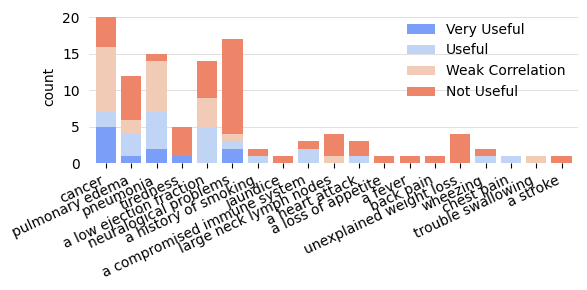

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(6, 3))
chart = query_counts.rename(
    columns={0: 'Not Useful', 1: 'Weak Correlation', 2: 'Useful', 3: 'Very Useful'},
    index=lambda x: x.split(' (')[0],
    )[['Very Useful', 'Useful', 'Weak Correlation', 'Not Useful']].plot(
    kind='bar', stacked=True, color=sns.color_palette("coolwarm", 4),
    width=0.8,
    ax=axs)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=25,
    horizontalalignment='right'
)
chart.legend(frameon=False)
chart.set_ylabel('count')
chart.grid(True, axis='y', linestyle='-', linewidth=0.5, color='lightgray')
chart.yaxis.set_tick_params(width=0)
chart.set_axisbelow(True)
fig.tight_layout()
fig.savefig('figures/query_usefulness.pdf')

In [31]:
processed_df.columns

Index(['annotator', 'instance_index', 'num_reports', 'model_type', 'sort_type',
       'prediction_aligns', 'time_for_initial_assesment', 'cancer in future',
       'pneumonia in future', 'pulmonary edema in future',
       'num_annotated_evidence', 'is_duplicate', 'notes', 'score', 'evidence',
       'query', 'day', 'report_number', 'evidence_was_seen',
       'cancer relevance', 'cancer impact', 'pneumonia relevance',
       'pneumonia impact', 'pulmonary edema relevance',
       'pulmonary edema impact', 'cancer', 'pneumonia', 'pulmonary edema',
       'cancer(changed)', 'pneumonia(changed)', 'pulmonary edema(changed)',
       'precentage_seen'],
      dtype='object')

In [36]:
processed_df_temp = processed_df.copy()
processed_df_temp = processed_df_temp[
    (~processed_df_temp['cancer(changed)'].isna()) |
    (~processed_df_temp['pneumonia(changed)'].isna()) |
    (~processed_df_temp['pulmonary edema(changed)'].isna())]
# processed_df_temp['max_evidence_score'] = max(
#     processed_df_temp['max_evidence_score'])
models = {'llm_evidence': 'LLM Evidence', 'all_sentences': 'All EHR'}
sort_methods = {'Sort by MSE with the bias logits': 'Log Odds Sorting', 'LLM Confidence': 'Confidence Sorting'}
processed_df_temp['Model'] = processed_df_temp.model_type.apply(lambda x: models[x])
processed_df_temp['Sorting'] = processed_df_temp.sort_type.apply(lambda x: sort_methods[x])
conditions = ['cancer', 'pulmonary edema', 'pneumonia']
def get_best_evidence_index(row):
    sorted_evidence = sorted(zip(range(len(row['evidence'])), *[row[f'{d} relevance'] for d in conditions]), key=lambda x: max(x[1:]))
    return sorted_evidence[-1][0]
processed_df_temp['best_evidence_idx'] = processed_df_temp.apply(get_best_evidence_index, axis=1)
processed_df_temp['Best Evidence'] = processed_df_temp.apply(
    lambda r: r.evidence[r.best_evidence_idx].replace('\n', '. '), axis=1)
for d in conditions:
    processed_df_temp[d.title()] = processed_df_temp.apply(
        lambda r: r[f'{d} relevance'][r.best_evidence_idx], axis=1)
verbalizers = ['Not Relevant to ', 'Weak Correlation with ', 'Useful for ', 'Very Useful for ']
def get_usefulness(r):
    max_score = max([r[f'{d} relevance'][r.best_evidence_idx] for d in conditions])
    return verbalizers[max_score] + ', '.join(
        ['\\textbf{' + d.title() + '}' for d in conditions if r[f'{d} relevance'][r.best_evidence_idx] == max_score])
processed_df_temp['Usefulness'] = processed_df_temp.apply(get_usefulness, axis=1)
def get_label(r):
    return ', '.join([c.title() for c in conditions if r[c + ' in future']])
processed_df_temp['Synthetic Label'] = processed_df_temp.apply(get_label, axis=1)
processed_df_temp['Changes'] = processed_df_temp.apply(
    lambda r: ', '.join([f'{d.title()}: {r[d]} $\\rightarrow$ ' + r[d+'(changed)'] for d in conditions if r[d+'(changed)'] == r[d+'(changed)']]), axis=1)
annotators = {
    'Andrea': '1',
    'Lucy': '2',
    'William': '3',
    'Geoff': '4',
}
processed_df_temp['Annotator'] = processed_df_temp.annotator.apply(lambda x: annotators[x])
processed_df_temp = processed_df_temp.rename(columns={'instance_index': 'Instance'})
processed_df_temp = processed_df_temp[['Instance', 'report_number', 'Annotator', 'Model', 'Sorting', 'Changes', 'Best Evidence', 'Usefulness', 'Synthetic Label', 'cancer relevance', 'pneumonia relevance', 'pulmonary edema relevance', 'cancer in future', 'pneumonia in future', 'pulmonary edema in future']]
processed_df_temp


,Instance,report_number,Annotator,Model,Sorting,Changes,Best Evidence,Usefulness,Synthetic Label,cancer relevance,pneumonia relevance,pulmonary edema relevance,cancer in future,pneumonia in future,pulmonary edema in future
17,84,"[9, 3, 3, 6]",3,All EHR,Log Odds Sorting,Cancer: Unlikely $\rightarrow$ Very likely,Basal cell skin ca. [**27**].,Useful for \textbf{Cancer},Pulmonary Edema,"[2, 0, 0, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]",False,False,True
26,121,"[23, 34]",1,LLM Evidence,Log Odds Sorting,Pneumonia: Somewhat likely $\rightarrow$ Very ...,"CXR showed L middle/lower lobe PNA, prob asp PNA.",Very Useful for \textbf{Pneumonia},,"[0, 0]","[1, 3]","[1, 0]",False,False,False
35,62,"[3, 10]",4,All EHR,Log Odds Sorting,Cancer: Unlikely $\rightarrow$ Somewhat likely,"o.b.resident to see pt., pt.waiting for a ""bio...",Useful for \textbf{Cancer},Pulmonary Edema,"[2, 2]","[0, 0]","[0, 0]",False,False,True
51,86,"[1, 15, 2]",2,LLM Evidence,Confidence Sorting,Pneumonia: Unlikely $\rightarrow$ Somewhat likely,There is a small right pneumothorax. There is ...,Useful for \textbf{Pneumonia},Pneumonia,"[0, 0, 1]","[0, 0, 2]","[0, 0, 0]",False,True,False
54,137,"[7, 9, 2]",4,LLM Evidence,Confidence Sorting,Pulmonary Edema: Unlikely $\rightarrow$ Somewh...,Atrial fibrillation with rapid ventricular res...,Useful for \textbf{Pulmonary Edema},Pulmonary Edema,"[0, 0, 0]","[0, 0, 0]","[2, 2, 2]",False,False,True
58,139,"[4, 12, 1, 2, 1]",4,All EHR,Log Odds Sorting,Pulmonary Edema: Somewhat likely $\rightarrow$...,There is increased opacity in the. retrocardi...,Very Useful for \textbf{Pneumonia},,"[0, 0, 0, 0, 0]","[0, 1, 0, 0, 3]","[1, 0, 0, 0, 0]",False,False,False
60,144,"[10, 11, 9, 8]",4,LLM Evidence,Log Odds Sorting,Cancer: Unlikely $\rightarrow$ Very likely,CLL. Signs: id: pmh of CLL,Very Useful for \textbf{Cancer},,"[3, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 2, 0]",False,False,False


In [37]:
instance_order = [
    86,
    137,
    84,
    62,
    139,
    121,
    144,
]
processed_df_temp_ordered = pd.concat([
    processed_df_temp[processed_df_temp.Instance == ii]
    for ii in instance_order
])
instance_map = {inst: i for i, inst in enumerate(instance_order)}
processed_df_temp_ordered['Instance'] = processed_df_temp_ordered.Instance.apply(lambda x: instance_map[x])
processed_df_temp_ordered

,Instance,report_number,Annotator,Model,Sorting,Changes,Best Evidence,Usefulness,Synthetic Label,cancer relevance,pneumonia relevance,pulmonary edema relevance,cancer in future,pneumonia in future,pulmonary edema in future
51,0,"[1, 15, 2]",2,LLM Evidence,Confidence Sorting,Pneumonia: Unlikely $\rightarrow$ Somewhat likely,There is a small right pneumothorax. There is ...,Useful for \textbf{Pneumonia},Pneumonia,"[0, 0, 1]","[0, 0, 2]","[0, 0, 0]",False,True,False
54,1,"[7, 9, 2]",4,LLM Evidence,Confidence Sorting,Pulmonary Edema: Unlikely $\rightarrow$ Somewh...,Atrial fibrillation with rapid ventricular res...,Useful for \textbf{Pulmonary Edema},Pulmonary Edema,"[0, 0, 0]","[0, 0, 0]","[2, 2, 2]",False,False,True
17,2,"[9, 3, 3, 6]",3,All EHR,Log Odds Sorting,Cancer: Unlikely $\rightarrow$ Very likely,Basal cell skin ca. [**27**].,Useful for \textbf{Cancer},Pulmonary Edema,"[2, 0, 0, 1]","[0, 0, 0, 0]","[0, 0, 0, 0]",False,False,True
35,3,"[3, 10]",4,All EHR,Log Odds Sorting,Cancer: Unlikely $\rightarrow$ Somewhat likely,"o.b.resident to see pt., pt.waiting for a ""bio...",Useful for \textbf{Cancer},Pulmonary Edema,"[2, 2]","[0, 0]","[0, 0]",False,False,True
58,4,"[4, 12, 1, 2, 1]",4,All EHR,Log Odds Sorting,Pulmonary Edema: Somewhat likely $\rightarrow$...,There is increased opacity in the. retrocardi...,Very Useful for \textbf{Pneumonia},,"[0, 0, 0, 0, 0]","[0, 1, 0, 0, 3]","[1, 0, 0, 0, 0]",False,False,False
26,5,"[23, 34]",1,LLM Evidence,Log Odds Sorting,Pneumonia: Somewhat likely $\rightarrow$ Very ...,"CXR showed L middle/lower lobe PNA, prob asp PNA.",Very Useful for \textbf{Pneumonia},,"[0, 0]","[1, 3]","[1, 0]",False,False,False
60,6,"[10, 11, 9, 8]",4,LLM Evidence,Log Odds Sorting,Cancer: Unlikely $\rightarrow$ Very likely,CLL. Signs: id: pmh of CLL,Very Useful for \textbf{Cancer},,"[3, 0, 0, 0]","[0, 1, 0, 0]","[0, 0, 2, 0]",False,False,False


In [38]:
columns = processed_df_temp_ordered.columns[2:-6]
latex_table = " & ".join(columns) + " \\\\\n\hline\n"
for i, row in processed_df_temp_ordered.iterrows():
    latex_table += " & ".join([str(row[c]) for c in columns]) + " \\\\\n"
print(latex_table)

Annotator & Model & Sorting & Changes & Best Evidence & Usefulness & Synthetic Label \\
\hline
2 & LLM Evidence & Confidence Sorting & Pneumonia: Unlikely $\rightarrow$ Somewhat likely & There is a small right pneumothorax. There is extensive consolidation of the right upper lobe. Consolidation in the right lower lobe is mostly located in the superior segment. The left lung is grossly clear. There. Signs: There is extensive consolidation of the right upper lobe. Consolidation in the right lower lobe is mostly located in the superior segment. The left lung is grossly clear. There is no left pleural effusion. There is & Useful for \textbf{Pneumonia} & Pneumonia \\
4 & LLM Evidence & Confidence Sorting & Pulmonary Edema: Unlikely $\rightarrow$ Somewhat likely & Atrial fibrillation with rapid ventricular response. Compared to the previous tracing atrial fibrillation is seen. Other findings are similar. The patient is at risk of pulmonary edema. & Useful for \textbf{Pulmonary Edema} & Pulmo